<a href="https://colab.research.google.com/github/PaoDeV99/ML_Progetto1_G72/blob/master/p1_g72_gboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Gradient Boosting Classifier**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


22/06, ore 00:03 <br/>
gbc non accetta in ingresso direttive sul decision tree classifier. Questo vuol dire niente gini (anche se dovrebbe essere impostata di default per i dtc) e niente impostazione sulla max depth (si può ovviare andando ad operare su min_samples_split, ma non sarebbe esattamente la stessa cosa). <br/>
<br/>
Il notebook presenta ancora i risultati di una run di gbc con n_estimators=1000. È stato predisposto per runnare in un ciclo comandato dal numero di stimatori, che varia secondo i valori di estimators. Va ancora impostato per bene il ciclo, prima di farlo runnare. Raccomando pazienza per quando si deciderà di farlo partire: prospetto un tempo di run abbastanza lungo, intorno ai 70 minuti. <br/>
<br/>
Vanno aggiunte delle celle che si occuppino di produrre i plot dell'accuracy al variare del numero di stimatori, così come del tempo di run (ispirati a randomforest). <br/>
<br/>
Finito il lavoro descritto sopra, puoi implementare una feature importance e vedere se e cosa cambia. <br/>
<br/>
Se hai fatto anche quello, perché non tentare la sorte con una random forest classica? O con una logistic regression? A scopo puramente accademico, sarebbe interessante vedere se la logistic regression di oggi riesce a battere il prototipo di gbc e abc.

22/06, ore 22:42 <br/>
Ho inserito la possibilità di collegare il notebook al drive, in modo da non dover ricaricare a mano il txt dei dati ad ogni sessione di lavoro. <br/>
Ho terminato la stesura del ciclo di run di gbc. È impostato per runnare con 100, 200, 500, 800 e 1000 stimatori. Vengono registragti tempo di run, training accuracy, test accuracy e confusion matrix. Ho commentato le celle relative all'impostazione precedente del notebook. <br/>
(Nota a margine: i print effettuati non sono quelli impostati nelle celle. Le modifiche, volte a favorire un'estetica migliore nei print, sono state effettuate solo dopo aver fatto partire il ciclo.)

24/06, ore 16:41 <br/>
Su suggerimento di @Zdestrion, ho aggiunto una cella di reshuffling del dataset, in modo da presentare dati relativi a rumore a segnale in quantità più simili possibile a training set e test set. I risultati cambiano di un nulla.

28/06, ore 01:13 <br/>
Ho aggiunto una regressione logistica con regolarizzazione L2. Ci sono dei problemi con il plot degli istogrammi delle probabilità delle due classi.<br/>
Cose ancora da fare:
*   Aggiungere le funzioni di plot delle accuracy e del tempo di run di gbc.
*   Aggiungere anche valori intermedi di stimatori, per avere più dati.
*   Implementare una feature importance con numero di stimatori cui risulta associata l'accuracy migliore (evidentemente 1000).
*   Provare ad operare una separazione tramite pca e tsne.



29/06, ore 00:53 <br/>
Risolto il problema del plot della regressione logistica. <br/>
Ho provato ad implementare pca e tsne. La divergenza kl non è male, ma il plot è più una macchia di rorschach che altro.

In [2]:
import numpy as np
import pandas as pd
import time
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_fwf('/content/drive/My Drive/Colab Notebooks/MiniBooNE_PID.txt')

In [4]:
df

,36499 93565,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.885000,0.928671,0.140918,2.58663,1689.070,1.197950,19.35610,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.222990,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.37300,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.718000,0.882784,0.368855,2.24638,1388.260,0.839230,6.69510,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.317170,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.95970,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.396000,0.412250,0.434002,2.38485,992.098,0.514175,16.00300,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.187650,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.56080,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.865600,0.833067,0.181294,2.49837,1289.160,0.630307,12.93740,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.700340,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.45860,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.668000,0.398421,0.353034,2.04136,949.231,0.389585,13.91750,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.687930,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.96000,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.80718,1.451020,174.6920,0.343481,0.002174,0.000000,0.747401,0.725617,3.18501,0.152208,4.09329,-0.707947,0.813344,0.015294,1.83104,520.017,0.192353,7.59299,0.271739,0.580181,2.706590,0.321739,18.9165,4.77587,0.488641,0.578023,106.1100,1.827670,0.174318,0.523787,7.59281,1.451220,0.616285,453.588,0.015260,0.291661,-0.445277,-3.02319,1.513750,0.055040,179.832,-2.74376,0.317051,2.67617,0.000000,0.141958,0.723207,7.446300,3.219320,0.299487
130060,5.00527,1.501860,129.9270,0.273477,0.006098,0.109769,1.325370,0.830334,3.40836,0.130794,4.23870,49.729900,0.527637,0.337350,2.32783,779.822,0.295920,12.35990,0.280488,1.630800,-0.447177,0.302846,64.8961,2.66737,0.443424,-0.060302,149.7250,1.565400,0.138097,0.199993,7.29614,1.130380,1.100050,414.089,0.072055,0.288639,0.780298,-2.74524,1.216240,0.110098,120.794,-24.72180,0.312652,4.16524,0.000000,0.232273,0.141153,1.898750,1.778180,0.258058
130061,3.10842,2.178140,56.3651,0.211850,0.000000,0.167382,1.318900,0.870681,

In [5]:
df["signal"]=0
df.iloc[0:36498,50]=1
df.iloc[36499:,50]=0
df

,36499 93565,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,signal
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.885000,0.928671,0.140918,2.58663,1689.070,1.197950,19.35610,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.222990,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.37300,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.718000,0.882784,0.368855,2.24638,1388.260,0.839230,6.69510,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.317170,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.95970,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.396000,0.412250,0.434002,2.38485,992.098,0.514175,16.00300,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.187650,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.56080,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.865600,0.833067,0.181294,2.49837,1289.160,0.630307,12.93740,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.700340,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.45860,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.668000,0.398421,0.353034,2.04136,949.231,0.389585,13.91750,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.687930,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.96000,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.80718,1.451020,174.6920,0.343481,0.002174,0.000000,0.747401,0.725617,3.18501,0.152208,4.09329,-0.707947,0.813344,0.015294,1.83104,520.017,0.192353,7.59299,0.271739,0.580181,2.706590,0.321739,18.9165,4.77587,0.488641,0.578023,106.1100,1.827670,0.174318,0.523787,7.59281,1.451220,0.616285,453.588,0.015260,0.291661,-0.445277,-3.02319,1.513750,0.055040,179.832,-2.74376,0.317051,2.67617,0.000000,0.141958,0.723207,7.446300,3.219320,0.299487,0
130060,5.00527,1.501860,129.9270,0.273477,0.006098,0.109769,1.325370,0.830334,3.40836,0.130794,4.23870,49.729900,0.527637,0.337350,2.32783,779.822,0.295920,12.35990,0.280488,1.630800,-0.447177,0.302846,64.8961,2.66737,0.443424,-0.060302,149.7250,1.565400,0.138097,0.199993,7.29614,1.130380,1.100050,414.089,0.072055,0.288639,0.780298,-2.74524,1.216240,0.110098,120.794,-24.72180,0.312652,4.16524,0.000000,0.232273,0.141153,1.898750,1.778180,0.258058,0
130061,3.10842,2.178140,56.3651,0.211850,0.000000,0.

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

In [37]:
 x_train, x_test, y_train, y_test = train_test_split(
   df.iloc[:,0:50], df["signal"], test_size=0.33, random_state=42)

In [ ]:
estimators = [100, 200, 500, 800, 1000]

m=len(estimators)
#n=len(leaf_size_list)

#Allocate Arrays for various quantities
gbc_train_accuracy=np.zeros((m))
gbc_test_accuracy=np.zeros((m))
run_time=np.zeros((m))

for i, nest in enumerate(estimators):
  # Define Gradient Boosting Classifier
  gbc = GradientBoostingClassifier(n_estimators=nest, min_samples_split=2, random_state=0, warm_start=True)
        
  print('n_estimators: %i'%(nest))
        
  start_time = time.time()
  gbc.fit(x_train, y_train)
  run_time[i] = time.time() - start_time    
    
  # check accuracy
  gbc_train_accuracy[i]=gbc.score(x_train,y_train)
  gbc_test_accuracy[i]=gbc.score(x_test,y_test)
  predictions = gbc.predict(x_test)
        
  result = (run_time[i], gbc_train_accuracy[i], gbc_test_accuracy[i])
  print('{0:<15}{1:<15}{2:<15}'.format("time (s)","train score", "test score"))
  print('{0:<15.4f}{1:<15.4f}{2:<15.4f}'.format(*result))
  print('\nConfusion matrix:')
  print(confusion_matrix(y_test, predictions))
  print('\n')

n_estimators: 100
time (s)       train score    test score     
208.3463       0.9325         0.9286         

Confusion matrix:
[[29280  1511]
 [ 1554 10577]]


n_estimators: 200
time (s)       train score    test score     
397.8620       0.9403         0.9350         

Confusion matrix:
[[29371  1420]
 [ 1370 10761]]


n_estimators: 500
time (s)       train score    test score     
1008.2167      0.9507         0.9392         

Confusion matrix:
[[29447  1344]
 [ 1264 10867]]


n_estimators: 800
time (s)       train score    test score     
1640.7054      0.9569         0.9409         

Confusion matrix:
[[29467  1324]
 [ 1212 10919]]


n_estimators: 1000
time (s)       train score    test score     
2083.1156      0.9599         0.9416         

Confusion matrix:
[[29474  1317]
 [ 1189 10942]]




#**Regressione logistica**

In [8]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV()

start_time = time.time()
logreg.fit(x_train, y_train)
logreg_runtime = time.time() - start_time
logregacc = logreg.score(x_test, y_test)
logregpred = logreg.predict(x_test)

logreg_result = (logreg_runtime, logregacc)
print('{0:<15}{1:<15}'.format("time (s)", "test score"))
print('{0:<15.4f}{1:<15.4f}'.format(*logreg_result))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, logregpred))

time (s)       test score     
110.3727       0.8976         

Confusion matrix:
[[29097  1648]
 [ 2748  9429]]




In [9]:
logreg_prob = logreg.predict_proba(x_test)
print(logreg_prob)

[[0.99484806 0.00515194]
 [0.99540617 0.00459383]
 [0.08944715 0.91055285]
 ...
 [0.97070181 0.02929819]
 [0.99682617 0.00317383]
 [0.99263105 0.00736895]]


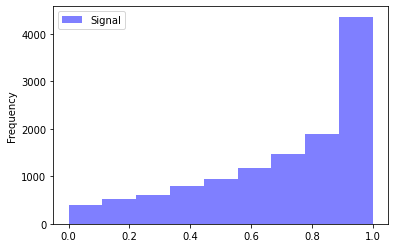

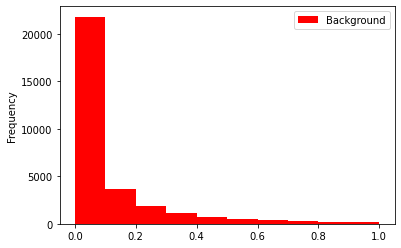

In [45]:
# grafico delle probabilità delle due classi:
y_test = pd.Series(y_test).values
df_test_acc = pd.DataFrame({'PROB':logreg_prob[:,1]})
df_test_acc['SIG'] = y_test

df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

#**PCA e TSNE**

In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

seed=12345

In [47]:
np.random.seed(seed)
rndperm = np.random.permutation(df.shape[0])

# selezioniamo i primi 10k eventi dal dataframe 
N = 50000
df_subset = df.loc[rndperm[:N],:].copy()
df_copy=df_subset
df_subset = df_subset.drop(columns= 'signal')
columns=["lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

data_subset = df_subset.values

pca_10 = PCA(n_components=10)
pca_result_10 = pca_10.fit_transform(data_subset)
print('Cumulative explained variation for 10 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000)
tsne_pca_results = tsne.fit_transform(pca_result_10)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Cumulative explained variation for 10 principal components: 0.9999998829258525
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.112s...
[t-SNE] Computed neighbors for 50000 samples in 14.354s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabil

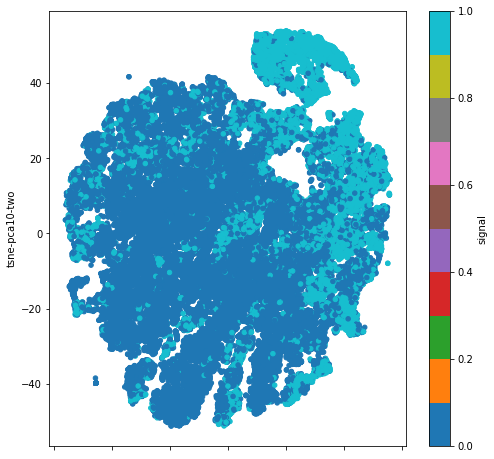

In [48]:
df_subset['tsne-pca10-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca10-two'] = tsne_pca_results[:,1]
df_subset['signal'] = df_copy['signal']
ax4=df_subset.plot.scatter(x="tsne-pca10-one", y="tsne-pca10-two", c='signal', colormap='tab10',figsize=(8,8))